# Sentiment Analysis on a Federal Docket: "Endangered and Threatened Species: Critical Habitat Designations for Florida Manatee and Antillean Manatee"

<b>Definitions</b><br>
- A docket is a collection of documents/text/information related to a rulemaking or regulatory action
- Regulation.gov is a centralized and public repository for these dockets. This enables transparency, and enables the public to get updated on regulatory actions
- Dockets will include a calendar of dates of the different proceedings


<b>AI-guided experimental summarization and sentiment
analysis of Dockets:</b> https://www.fda.gov/media/171124/download

<b>Summary of exercise:</b>

- Select a recent, high-impact federal regulation docket from regulations.gov.
- Extract relevant data from the docket, including the proposed regulation and associated
public comments. (Note: You may select a subset of the data for analysis.)
- Perform exploratory data analysis (EDA) to explore and display key characteristics of the
textual data.
- Identify themes and extract insights from the documents.
- Apply sentiment analysis techniques to assess the public comments. Consider how
bot-generated inputs might differ from human comments.


<b>Deliverables:</b>

1. Develop a Python script that performs a comprehensive analysis of the data. You may use
either a Jupyter notebook or a standalone .py script for the implementation.
- a. Along with the source code, include a README.md file in Markdown format which
documents your solution and how to use it. Deliver the application via shared git
repository (e.g. GitHub, BitBucket).
2. Given the above, present your findings in a concise format to business stakeholders (you
can use a short summary document or a few presentation slides).
- a. Be prepared to talk about your decision-making at a high level, for tech stack,
model selection, and implementation.

1. Extract comments
2. Remove Duplicated Comments
3. Identify sub-groups of related comments
4. Understand Sentiments of docket comments
5. Create Summary of docket comments

# 1. Data Extraction

Using the US Gov's API key, we can the docket info from the website as well as the comments:

In [110]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed") 
from comments_downloader import CommentsDownloader


Getting Comment Data:

In [ ]:
from comments_downloader import CommentsDownloader
# Replace with your actual API key
api_key = 'BgYDvERglnMGIokigbAPUZW7KslCI1gMWa5OjEsp'
downloader = CommentsDownloader(api_key)
docket_id = 'OSHA-2021-0009-4761' 
downloader.gather_comments_by_docket(docket_id=docket_id, db_filename="testdb.db", csv_filename=r'c:\Users\U355394\Desktop\doc_comments.csv')

Extracting the document information: We save the document metadata, then save the text, then export to json since excel has a size limit in each cell

In [66]:
import requests
import os
from PyPDF2 import PdfReader
import pandas as pd
import json 
# Replace with your actual API key
api_key = 'BgYDvERglnMGIokigbAPUZW7KslCI1gMWa5OjEsp'

# Base URL for the API
base_url = 'https://api.regulations.gov/v4'


# Function to get document metadata
def get_document_metadata(document_id):
    url = f'{base_url}/documents/{document_id}'
    headers = {'X-Api-Key': api_key}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        print(f'Error: {response.status_code} - {response.text}')
        return None

# Function to download a file
def download_file(url, save_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f'File downloaded: {save_path}')
    else:
        print(f'Error: {response.status_code} - {response.text}')

# Function to extract text from PDF
def extract_text_from_pdf(file_path):
    text = ""
    try:
        pdf_reader = PdfReader(file_path)
        for page in pdf_reader.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text
    except Exception as e:
        print(f"Error reading PDF file {file_path}: {e}")
    return text

# Main script
document_id = 'OSHA-2021-0009-0178'  # Replace with your document ID
metadata = get_document_metadata(document_id)

if metadata:
    # Ensure 'fileFormats' exists in the metadata
    if 'fileFormats' in metadata['data']['attributes']:
        file_formats = metadata['data']['attributes']['fileFormats']
        documents = []
        for file_format in file_formats:
            file_url = file_format['fileUrl']
            file_name = os.path.basename(file_url)
            save_path = f"./{file_name}"
            # Download the file
            download_file(file_url, save_path)
            # Extract text from the file
            text = ""
            if file_name.endswith(".pdf"):
                text = extract_text_from_pdf(save_path)
            # Prepare document data
            document_data = {
                "document_id": document_id,
                "file_name": file_name,
                "text": text,
                "metadata": metadata['data']['attributes']  # Include all attributes dynamically
            }
            documents.append(document_data)
        # Save all documents to a JSON file
        json_filename = "Doc_OSHA-2021-0009-0178.json"
        with open(json_filename, 'w', encoding='utf-8') as json_file:
            json.dump(documents, json_file, ensure_ascii=False, indent=4)
        print(f"Data saved to '{json_filename}'")
    else:
        print('No file formats available for this document.')
else:
    print('Failed to retrieve metadata.')


File downloaded: ./content.pdf
File downloaded: ./content.htm
Data saved to 'Doc_OSHA-2021-0009-0178.json'


<b>Importing Document Data</b>

In [216]:
def process_json_file(file_path):
    """
    Process a single JSON file and return a pandas DataFrame with relevant data.
    """
    with open(file_path, 'r', encoding='utf-8') as json_file:
        # Load JSON data
        data = json.load(json_file)
        
        # Convert JSON data to a DataFrame
        df = pd.DataFrame(data)
        
        # Normalize metadata if it exists
        if 'metadata' in df.columns:
            metadata_df = pd.json_normalize(df['metadata'])
            
            # Concatenate metadata with the original DataFrame
            df = pd.concat([df.drop(columns=['metadata']), metadata_df], axis=1)
        
        # Rename columns as per the requirements
        column_renames = {
            "document_id": "Document_ID",
            "docAbstract": "Abstract",
            "commentStartDate": "Comment_Start_Date",
            "commentEndDate": "Comment_End_Date",
            "documentType": "Document_Type",
            "docketId": "Docket_ID",
            "postedDate": "Posted_Date",
            "text": "Text",
            'title': 'Title'
        }
        df.rename(columns=column_renames, inplace=True)
    
    return df

def process_all_json_files(folder_path):
    """
    Process all JSON files in a folder and concatenate them into a single DataFrame.
    """
    dataframes = []
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            # Process only JSON files
            file_path = os.path.join(folder_path, file_name)
            
            # Process each JSON file and append the resulting DataFrame
            df = process_json_file(file_path)
            dataframes.append(df)
    
    # Concatenate all DataFrames into one
    combined_df = pd.concat(dataframes, ignore_index=True)
    
    return combined_df

# Define the folder containing the JSON files
folder_path = r'C:\Users\U355394\Desktop\Personal Projects\Jsons_Other_Proposed_Rule'

# Process all JSON files and combine into a single DataFrame
combined_df = process_all_json_files(folder_path)

df_docs = combined_df.loc[:,['Document_ID', 'Docket_ID', 'Abstract', 'Document_Type', 'Title', 'Text', 'Comment_Start_Date', 'Comment_End_Date', 'Posted_Date']]
df_docs = df_docs.drop_duplicates(subset=['Document_ID']).reset_index(drop=True)
df_docs.head()

,Document_ID,Docket_ID,Abstract,Document_Type,Title,Text,Comment_Start_Date,Comment_End_Date,Posted_Date
0,OSHA-2021-0009-0001,OSHA-2021-0009,"Federal Register of October 27, 2021 (86 FR 59...",Proposed Rule,Heat Injury and Illness Prevention in Outdoor ...,"59309 Federal Register / Vol. 86, No. 205 / We...",2021-10-27T04:00:00Z,2022-01-27T04:59:59Z,2021-10-27T04:00:00Z
1,OSHA-2021-0009-0178,OSHA-2021-0009,"Federal Register of December 3, 2021. (86 FR 6...",Proposed Rule,Heat Injury and Illness Prevention in Outdoor ...,"68594 Federal Register / Vol. 86, No. 230 / Fr...",2021-12-03T05:00:00Z,2022-01-27T04:59:59Z,2021-12-03T05:00:00Z
2,OSHA-2021-0009-1059,OSHA-2021-0009,The purpose of this memorandum is to notify in...,Other,Memorandum Reopening the Comment Period on Hea...,"August 21, 2023 \nM\nEMORANDUM FOR: The Gene...",2023-08-22T04:00:00Z,2023-12-24T04:59:59Z,2023-08-22T04:00:00Z
3,OSHA-2021-0009-3949,OSHA-2021-0009,The purpose of this memorandum is to allow for...,Other,Memorandum Allowing OSHA’s Supporting and Rela...,Occupational Safety and Health Administration ...,2024-08-09T04:00:00Z,None,2024-08-09T04:00:00Z
4,OSHA-2021-0009-4761,OSHA-2021-0009,"Federal Register of August 30, 20204. (89 FR 7...",Proposed Rule,Heat Injury and Illness Prevention in Outdoor ...,"70698 Federal Register / Vol. 89, No. 169 / Fr...",2024-08-30T04:00:00Z,2024-12-31T04:59:59Z,2024-08-30T04:00:00Z


In [217]:
corpus = " ".join(df_docs['Text'].astype(str))
df_docs.loc[0, 'Corpus'] = corpus
df_docs['Corpus'] = df_docs['Corpus'].fillna('')
df_docs

,Document_ID,Docket_ID,Abstract,Document_Type,Title,Text,Comment_Start_Date,Comment_End_Date,Posted_Date,Corpus
0,OSHA-2021-0009-0001,OSHA-2021-0009,"Federal Register of October 27, 2021 (86 FR 59...",Proposed Rule,Heat Injury and Illness Prevention in Outdoor ...,"59309 Federal Register / Vol. 86, No. 205 / We...",2021-10-27T04:00:00Z,2022-01-27T04:59:59Z,2021-10-27T04:00:00Z,"59309 Federal Register / Vol. 86, No. 205 / We..."
1,OSHA-2021-0009-0178,OSHA-2021-0009,"Federal Register of December 3, 2021. (86 FR 6...",Proposed Rule,Heat Injury and Illness Prevention in Outdoor ...,"68594 Federal Register / Vol. 86, No. 230 / Fr...",2021-12-03T05:00:00Z,2022-01-27T04:59:59Z,2021-12-03T05:00:00Z,
2,OSHA-2021-0009-1059,OSHA-2021-0009,The purpose of this memorandum is to notify in...,Other,Memorandum Reopening the Comment Period on Hea...,"August 21, 2023 \nM\nEMORANDUM FOR: The Gene...",2023-08-22T04:00:00Z,2023-12-24T04:59:59Z,2023-08-22T04:00:00Z,
3,OSHA-2021-0009-3949,OSHA-2021-0009,The purpose of this memorandum is to allow for...,Other,Memorandum Allowing OSHA’s Supporting and Rela...,Occupational Safety and Health Administration ...,2024-08-09T04:00:00Z,None,2024-08-09T04:00:00Z,
4,OSHA-2021-0009-4761,OSHA-2021-0009,"Federal Register of August 30, 20204. (89 FR 7...",Proposed Rule,Heat Injury and Illness Prevention in Outdoor ...,"70698 Federal Register / Vol. 89, No. 169 / Fr...",2024-08-30T04:00:00Z,2024-12-31T04:59:59Z,2024-08-30T04:00:00Z,


<b>Importing Comment Data:</b>

In [218]:

import pandas as pd
df_comments = pd.read_csv(r'c:\Users\U355394\Desktop\doc_comments.csv')

df_comments = df_comments.drop(columns=['Unnamed: 8'])
df_comments.head()

,Comment_ID,Document_ID,AgencyID,City,Comment,Docket_ID,DocumentType,Time of Comment
0,OSHA-2021-0009-12956,OSHA-2021-0009-4761,OSHA,Philadelphia,Every worker deserves protection from extreme ...,OSHA-2021-0009,Public Submission,2024-10-09T20:05:05Z
1,OSHA-2021-0009-15413,OSHA-2021-0009-4761,OSHA,Mount Vernon,I fully support the Occupational Safety and He...,OSHA-2021-0009,Public Submission,2024-10-09T20:33:26Z
2,OSHA-2021-0009-13439,OSHA-2021-0009-4761,OSHA,Rancho Santa Margarita,Every worker deserves protection from extreme ...,OSHA-2021-0009,Public Submission,2024-10-09T20:10:40Z
3,OSHA-2021-0009-10699,OSHA-2021-0009-4761,OSHA,New York,I am writing to support the proposed OSHA rule...,OSHA-2021-0009,Public Submission,2024-09-26T16:23:32Z
4,OSHA-2021-0009-15026,OSHA-2021-0009-4761,OSHA,New Braunfels,I fully support the Occupational Safety and He...,OSHA-2021-0009,Public Submission,2024-10-09T20:28:53Z


While the comments are formatted with the help of the API, we only select columns which will be potentially relevant:

# 2. Data Pre-Processing

<b>Text Pre-Processing:</b> We remove the stop words, put comments in lower case, and Lemmatize data for Document and Comment Data

In [219]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


# Define preprocessing function
def preprocess_text_column(df, text_column):
    """
    Preprocesses the specified text column in the DataFrame and adds a new column named "Processed_ " for the processed text.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing the text column to preprocess.
    text_column (str): Name of the column containing the text to preprocess.
    
    Returns:
    pd.DataFrame: DataFrame with an added column for the processed text.
    """
    # Define the processed column dynamically
    processed_column = f"Processed_{text_column}"
    
    # Define helper functions
    def remove_signature_and_clean(text):
        """Removes email signatures and unwanted tags."""
        pattern = r"(sincerely|thank you)[\s\S]*$"
        cleaned_text = re.sub(pattern, '', text, flags=re.IGNORECASE)
        cleaned_text = re.sub(r"&lt; .*?&gt; ", "", cleaned_text)
        cleaned_text = remove_unintelligible_words(cleaned_text)
        return cleaned_text

    def remove_unintelligible_words(text):
        """Removes unintelligible words and unwanted characters."""
        text = re.sub(r"&amp;[a-z]+;", "", text)  # Remove HTML entities
        text = re.sub(r"[^\w\s]", "", text)  # Remove non-alphanumeric characters
        text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace
        return text

    # Initialize stopwords and lemmatizer
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()

    # Ensure the processed column exists
    if processed_column not in df.columns:
        df[processed_column] = ""

    # Preprocessing loop
    for index, text in df[text_column].items():
        # Step 1: Remove signatures and clean unintelligible words
        cleaned_text = remove_signature_and_clean(text)
        
        # Step 2: Replace '-' and '/' with a space
        cleaned_text = re.sub(r"[-/]", " ", cleaned_text)
        
        # Step 3: Tokenize and filter
        tokens = re.findall(r'\b\w+\b', cleaned_text.lower())
        filtered_tokens = [
            lemmatizer.lemmatize(word, pos=wordnet.VERB)
            for word in tokens
            if word not in stop_words and re.match(r"^[a-z]+$", word)
        ]
        
        # Step 4: Join tokens back into a string
        processed_comment = " ".join(filtered_tokens) if filtered_tokens else ""
        
        # Step 5: Assign processed text to the new column
        df.at[index, processed_column] = processed_comment

    return df


# Apply the preprocessing function
df_comments = preprocess_text_column(df_comments, text_column="Comment")
df_docs = preprocess_text_column(df_docs, text_column="Corpus")
df_docs = preprocess_text_column(df_docs, text_column="Text")

<b>Creating a corpus containing the text of all documents</b>

# 3. Exploratory Data Analysis

<b>Number of Duplicates:</b>

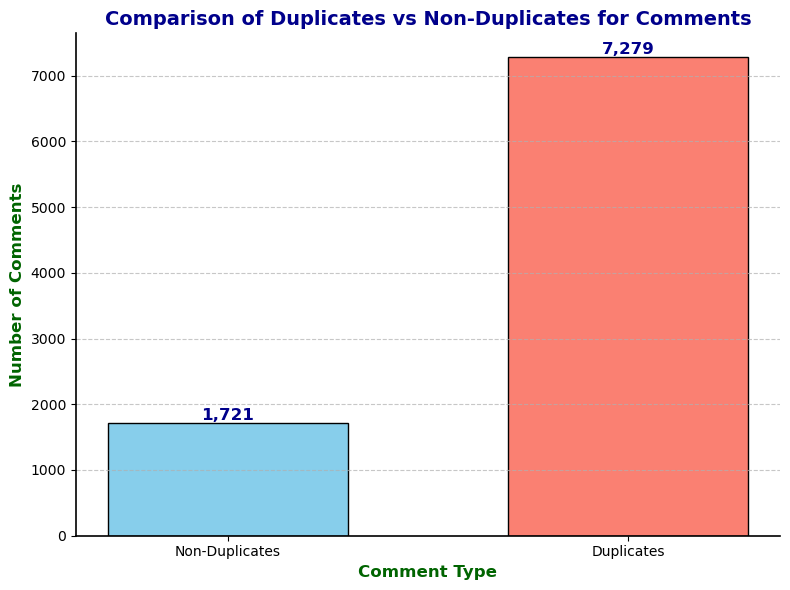

In [220]:
import matplotlib.pyplot as plt


# Calculate duplicates and non-duplicates
duplicates_count = df_comments["Processed_Comment"].duplicated(keep=False).sum()
non_duplicates_count = len(df_comments) - duplicates_count

# Data for the plot
labels = ['Non-Duplicates', 'Duplicates']
counts = [non_duplicates_count, duplicates_count]

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(labels, counts, color=['skyblue', 'salmon'], edgecolor='black', width=0.6)

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height + 1, f"{height:,}",  # Format the numbers with commas
        ha='center', va='bottom', fontsize=12, weight='bold', color='darkblue'
    )

# Style the plot
ax.set_title("Comparison of Duplicates vs Non-Duplicates for Comments", fontsize=14, fontweight='bold', color='darkblue')
ax.set_ylabel("Number of Comments", fontsize=12, fontweight='bold', color='darkgreen')
ax.set_xlabel("Comment Type", fontsize=12, fontweight='bold', color='darkgreen')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


<b>Duplicated Comments:</b> After Processing the comments, we find that a lot of them are identical

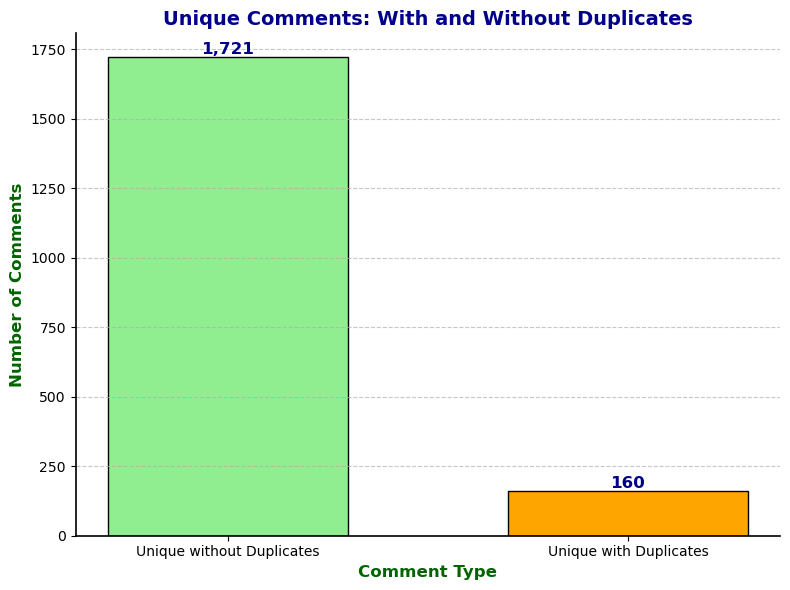

In [221]:

# Identify unique comments and categorize them
unique_comments = df_comments["Processed_Comment"].drop_duplicates(keep='first')  # Unique comments
total_unique = len(unique_comments)

# Count unique comments with and without duplicates
has_duplicates = df_comments["Processed_Comment"].duplicated(keep=False).groupby(df_comments["Processed_Comment"]).sum() > 1
unique_with_duplicates = has_duplicates.sum()
unique_without_duplicates = total_unique - unique_with_duplicates

# Data for the plot
labels = ['Unique without Duplicates', 'Unique with Duplicates']
counts = [unique_without_duplicates, unique_with_duplicates]

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(labels, counts, color=['lightgreen', 'orange'], edgecolor='black', width=0.6)

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height + 1, f"{height:,}",  # Format the numbers with commas
        ha='center', va='bottom', fontsize=12, weight='bold', color='darkblue'
    )

# Style the plot
ax.set_title("Unique Comments: With and Without Duplicates", fontsize=14, fontweight='bold', color='darkblue')
ax.set_ylabel("Number of Comments", fontsize=12, fontweight='bold', color='darkgreen')
ax.set_xlabel("Comment Type", fontsize=12, fontweight='bold', color='darkgreen')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


<b>Comment Similarity:</b> Let's look at the cosine similarity and find comments with the highest cosine similarity

In [223]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
# Example DataFrame
# Replace `df['Comment']` with your actual comment column
# df = pd.DataFrame({'Comment': ['comment1 text', 'comment2 text', ...]})

# Step 1: Vectorize the comments using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_comments['Comment'])

# Step 2: Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Step 3: Find the highest similarity score and corresponding comment for each comment
highest_similarity_scores = []
most_similar_comments = []
for i in range(len(cosine_sim)):
    # Exclude self-similarity (diagonal elements)
    cosine_sim[i, i] = 0
    max_sim_idx = cosine_sim[i].argmax()  # Index of the highest similarity score
    highest_similarity_scores.append(cosine_sim[i].max())  # Highest similarity score
    most_similar_comments.append(df_comments['Comment'][max_sim_idx])  # Corresponding comment

# Step 4: Add the highest similarity score and most similar comment as new columns
df_comments['Highest_Similarity_Score'] = highest_similarity_scores
df_comments['Most_Similar_Comment'] = most_similar_comments



<b>932 comments have a perfect cosine simialarity scores with other comments</b>

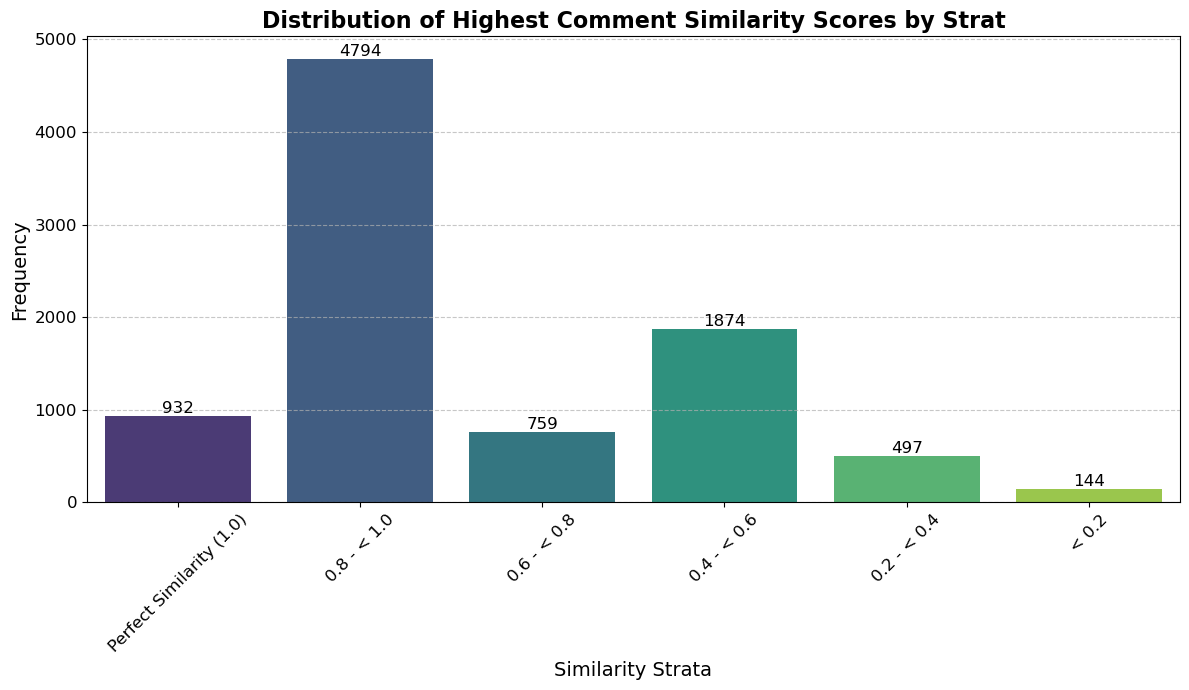

In [224]:
# Step 1: Bin the similarity scores into strata
def stratify_score(score):
    if score == 1.0:
        return "Perfect Similarity (1.0)"
    elif score >= 0.8:
        return "0.8 - < 1.0"
    elif score >= 0.6:
        return "0.6 - < 0.8"
    elif score >= 0.4:
        return "0.4 - < 0.6"
    elif score >= 0.2:
        return "0.2 - < 0.4"
    else:
        return "< 0.2"

df_comments['Similarity_Strat'] = df_comments['Highest_Similarity_Score'].apply(stratify_score)

# Step 2: Count the frequency of each strat and ensure all strata are included
strata_order = ["Perfect Similarity (1.0)", "0.8 - < 1.0", "0.6 - < 0.8", "0.4 - < 0.6", "0.2 - < 0.4", "< 0.2"]
strat_counts = df_comments['Similarity_Strat'].value_counts().reindex(strata_order, fill_value=0).reset_index()
strat_counts.columns = ['Similarity_Strat', 'Count']

# Step 3: Plot the data
plt.figure(figsize=(12, 7))
sns.barplot(data=strat_counts, x='Similarity_Strat', y='Count', palette='viridis')
plt.title('Distribution of Highest Comment Similarity Scores by Strat', fontsize=16, fontweight='bold')
plt.xlabel('Similarity Strata', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.bar_label(plt.gca().containers[0], fmt='%d', fontsize=12, label_type='edge')  # Add labels to bars
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<b>Analyzing Time Stamps Between Comments: </b> We find suspicious patterns with regards to bot activity

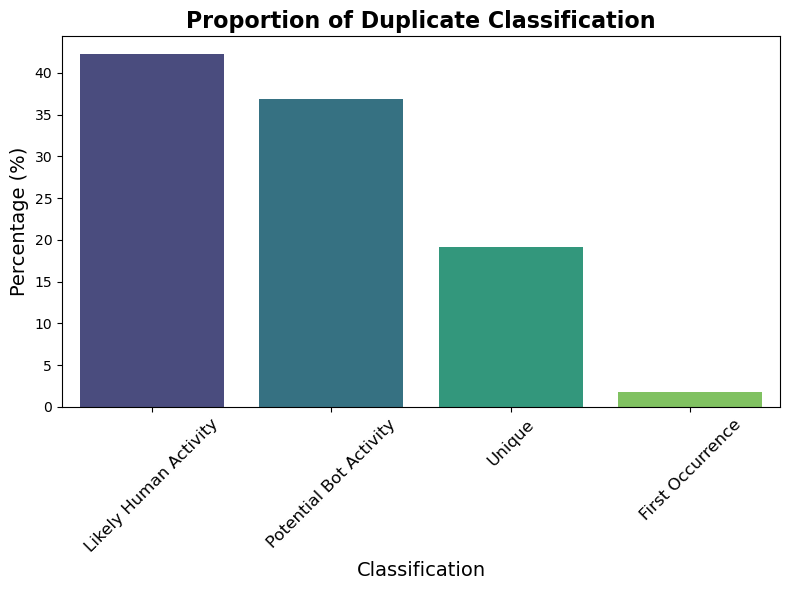

In [225]:
from datetime import timedelta
# Ensure 'Time of Comment' is a datetime object
df_comments['Time of Comment'] = pd.to_datetime(df_comments['Time of Comment'], format='%Y-%m-%dT%H:%M:%SZ')
# Step 1: Identify Duplicates
df_comments['Is_Duplicate'] = df_comments.duplicated(subset=['Processed_Comment'], keep=False)

# Step 2: Calculate Time Difference
# Sort by 'Processed_Comments' and 'Time_of_Comment' for accurate time difference calculation
df_comments = df_comments.sort_values(by=['Processed_Comment', 'Time of Comment']).reset_index(drop=True)

# Create a column for the time difference between consecutive duplicates
df_comments['Time_Difference'] = df_comments.groupby('Processed_Comment')['Time of Comment'].diff()

# Step 3: Apply Conditions Based on Time Difference
def classify_duplicate(row):
    if not row['Is_Duplicate']:
        return "Unique"
    elif pd.isnull(row['Time_Difference']):
        return "First Occurrence"
    elif row['Time_Difference'] <= timedelta(seconds=2):
        return "Potential Bot Activity"
    else:
        return "Likely Human Activity"

df_comments['Duplicate_Classification'] = df_comments.apply(classify_duplicate, axis=1)

# Display the result
df_comments[df_comments['Duplicate_Classification'] == 'Potential Bot Activity']

# Calculate Proportions
classification_counts = df_comments['Duplicate_Classification'].value_counts(normalize=True) * 100

# Plot 1: Proportion of Bot Activity
plt.figure(figsize=(8, 6))
sns.barplot(x=classification_counts.index, y=classification_counts.values, palette='viridis')
plt.title("Proportion of Duplicate Classification", fontsize=16, fontweight='bold')
plt.xlabel("Classification", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()


<b>Creation of Labels:</b>

In [ ]:
from sklearn import preprocessing
import numpy as np
# Flatten the array to 1D
comments_array = np.array(df_comments['Comment']).ravel()

# Encode the labels
encoder = preprocessing.LabelEncoder()
encoded_labels = encoder.fit_transform(comments_array)
df_comments['Labels'] = encoded_labels

<b>Removing Duplicates</b>

In [235]:
df_comments = df_comments.drop_duplicates(subset=['Processed_Comment']).dropna(subset=['Processed_Comment']).reset_index(drop=True)
df_comments

,index,Comment_ID,Document_ID,AgencyID,City,Comment,Docket_ID,DocumentType,Time of Comment,Processed_Comment,Highest_Similarity_Score,Most_Similar_Comment,Similarity_Strat,Is_Duplicate,Time_Difference,Duplicate_Classification,tokens,Comment_Length
0,0,OSHA-2021-0009-4889,OSHA-2021-0009-4761,OSHA,Oceanside,I sincerely ask our people to consider impleme...,OSHA-2021-0009,Public Submission,2024-09-09 17:30:11,,0.434691,Please implement the proposed heat regulations...,0.4 - < 0.6,True,NaT,First Occurrence,[],0
1,146,OSHA-2021-0009-5224,OSHA-2021-0009-4761,OSHA,Cockeysville,"As ab ex restaurant worker, I urge the Occupat...",OSHA-2021-0009,Public Submission,2024-09-10 17:06:57,ab ex restaurant worker urge occupational safe...,0.231926,I am writing to support the proposed OSHA rule...,0.2 - < 0.4,False,NaT,Unique,"[ab, ex, restaurant, worker, urge, occupationa...",45
2,147,OSHA-2021-0009-13753,OSHA-2021-0009-4761,OSHA,Buffalo,It is absolutely necessary to implement the pr...,OSHA-2021-0009,Public Submission,2024-10-09 20:14:14,absolutely necessary implement propose heat re...,0.611788,Please implement the proposed OSHA heat regula...,0.6 - < 0.8,False,NaT,Unique,"[absolutely, necessary, implement, propose, he...",68
3,148,OSHA-2021-0009-4852,OSHA-2021-0009-4761,OSHA,NaN,This is absolutely necessary and I am PM for a...,OSHA-2021-0009,Public Submission,2024-09-09 16:33:17,absolutely necessary pm general contractor bel...,0.281111,I can&#39;t believe we haven&#39;t had this in...,0.2 - < 0.4,False,NaT,Unique,"[absolutely, necessary, pm, general, contracto...",9
4,149,OSHA-2021-0009-18678,OSHA-2021-0009-4761,OSHA,NaN,We absolutely need heat protections for the wo...,OSHA-2021-0009,Public Submission,2024-11-13 15:56:26,absolutely need heat protections workplace wor...,0.376143,I used to work in food service. My job was to ...,0.2 - < 0.4,False,NaT,Unique,"[absolutely, need, heat, protections, workplac...",99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876,8995,OSHA-2021-0009-4803,OSHA-2021-0009-4761,OSHA,NaN,Yes it&#39;s about time!,OSHA-2021-0009,Public Submission,2024-09-09 13:32:42,yes time,0.646385,Yes it will absolutely.,0.6 - < 0.8,False,NaT,Unique,"[yes, time]",2
1877,8996,OSHA-2021-0009-15070,OSHA-2021-0009-4761,OSHA,Riverside,"Yes, yes, yes, I fully support the Occupationa...",OSHA-2021-0009,Public Submission,2024-10-09 20:29:23,yes yes yes fully support occupational safety ...,0.769561,I fully support the Occupational Safety and He...,0.6 - < 0.8,False,NaT,Unique,"[yes, yes, yes, fully, support, occupational, ...",138
1878,8997,OSHA-2021-0009-18615,OSHA-2021-0009-4761,OSHA,teaneck,"As a Young Jew, I believe that people must loo...",OSHA-2021-0009,Public Submission,2024-11-06 20:25:59,young jew believe people must look othersrsquo...,0.972451,"As a Jew, I believe that people must look out ...",0.8 - < 1.0,False,NaT,Unique,"[young, jew, believe, people, must, look, othe...",49
1879,8998,OSHA-2021-0009-7911,OSHA-2021-0009-4761,OSHA,Chicago,"As a young man, I worked in a steel mill and I...",OSHA-2021-0009,Public Submission,2024-09-19 16:44:32,young man work steel mill lucky union insist p...,0.863054,I am writing to support the proposed OSHA rule...,0.8 - < 1.0,False,NaT,Unique,"[young, man, work, steel, mill, lucky, union, ...",203


<b>Word Cloud and Term Frequency for comments and documents:</b>

<Figure size 800x500 with 0 Axes>

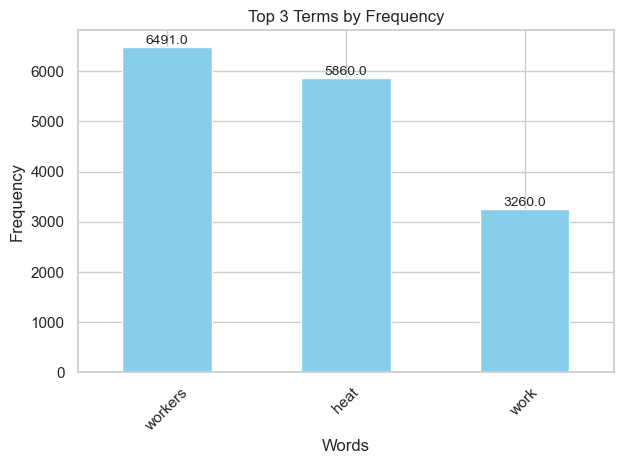

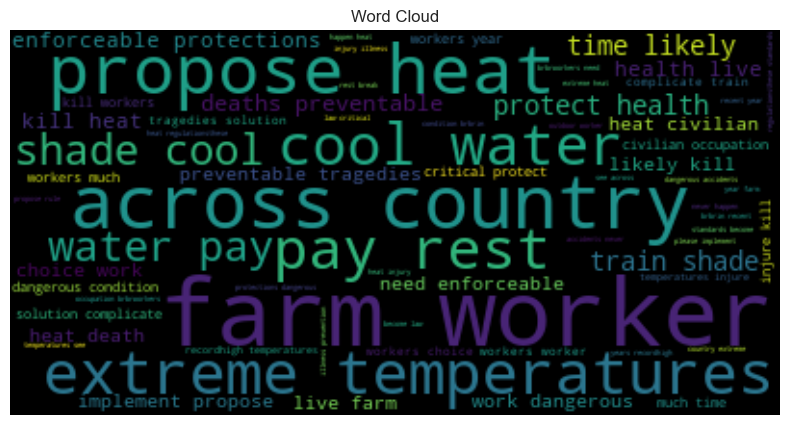

In [236]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

def plot_tf_and_wordcloud(df, column_name, max_font_size=50, max_words=100, background_color="black"):
    # 1. Term Frequency Calculation and Bar Chart
    tf = df[column_name].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
    tf.columns = ["words", "tf"]
    top_tf = tf.sort_values(by="tf", ascending=False).head(3)  # Retain only the top 3 terms
    
    plt.figure(figsize=(8, 5))
    ax = top_tf.plot.bar(x="words", y="tf", title="Top 3 Terms by Frequency", legend=False, color='skyblue')
    ax.set_xlabel("Words")
    ax.set_ylabel("Frequency")
    
    # Add value labels on each bar
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=10)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 2. Word Cloud Generation
    text = " ".join(i for i in df[column_name])
    wordcloud = WordCloud(max_font_size=max_font_size, max_words=max_words, background_color=background_color).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title("Word Cloud")
    plt.axis("off")
    plt.show()
plot_tf_and_wordcloud(df_comments, "Processed_Comment")


<b>For Documents</b>

<Figure size 800x500 with 0 Axes>

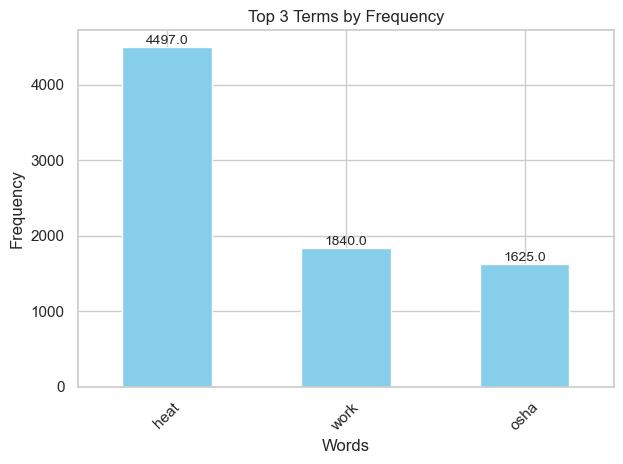

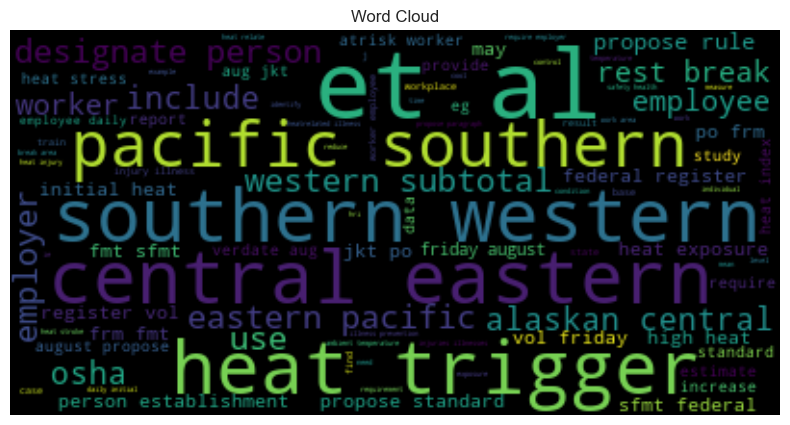

In [237]:
plot_tf_and_wordcloud(df_docs, "Processed_Corpus")

<b>Graph Showing the proportion per POS Tag:</b> This suggests that the majority is of the processed comments mostly contain nouns, following by a high count of adjectives, then plurial nouns

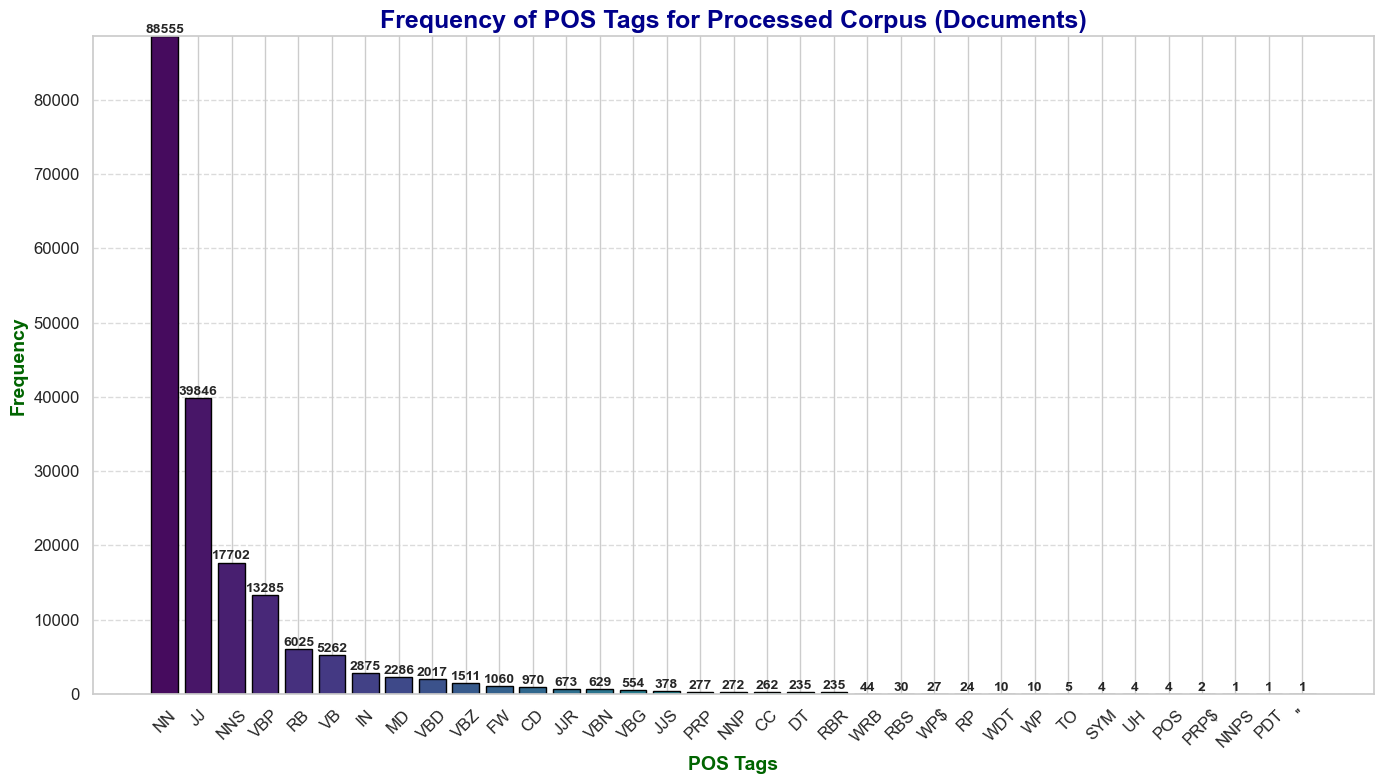

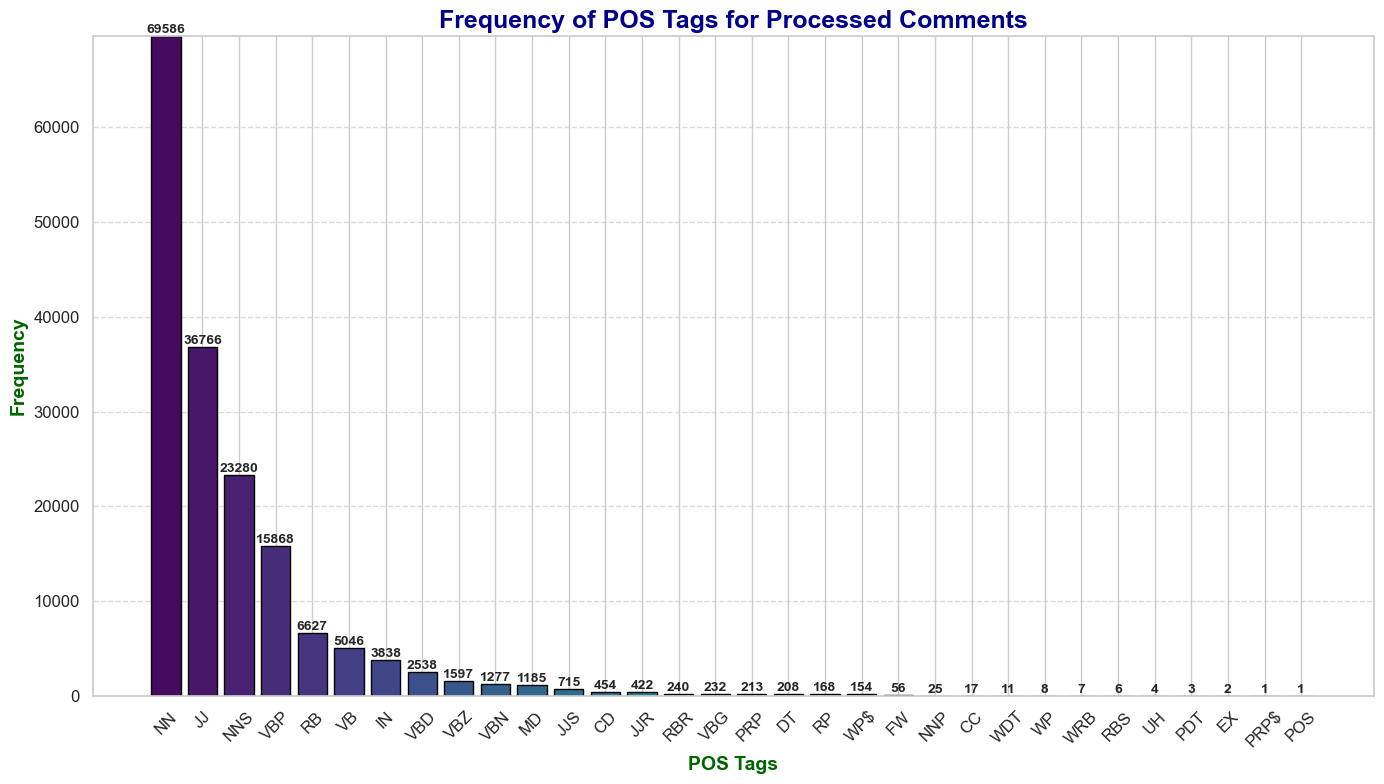

In [238]:
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
import seaborn as sns
# Assuming df is already processed and contains the 'Processed_Comments' column

# Function to perform POS tagging and generate a plot
def plot_pos_tags(df, column, title):
    # Tokenize the specified column
    df['tokens'] = df[column].apply(word_tokenize)
    
    # Flatten the list of tokenized sentences
    all_words = [word for sublist in df['tokens'] for word in sublist]
    
    # Perform POS tagging
    pos_tags = nltk.pos_tag(all_words)
    
    # Count the frequency of each POS tag
    pos_counts = Counter(tag for word, tag in pos_tags)
    
    # Sort the tags and counts by frequency in descending order
    sorted_pos_counts = sorted(pos_counts.items(), key=lambda item: item[1], reverse=True)
    
    # Separate tags and their counts for plotting
    tags, counts = zip(*sorted_pos_counts)
    
    # Set the style and color palette
    sns.set(style="whitegrid")
    palette = sns.color_palette("viridis", len(tags))
    
    # Create the bar plot
    plt.figure(figsize=(14, 8))
    bars = plt.bar(tags, counts, color=palette, edgecolor='black')
    
    # Add value labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Customize the appearance
    plt.title(title, fontsize=18, fontweight='bold', color='darkblue')
    plt.xlabel("POS Tags", fontsize=14, fontweight='bold', color='darkgreen')
    plt.ylabel("Frequency", fontsize=14, fontweight='bold', color='darkgreen')
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0, max(counts) + 10)
    
    # Add grid lines
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Apply the function to df_docs and df_comments
plot_pos_tags(df_docs, 'Processed_Corpus', "Frequency of POS Tags for Processed Corpus (Documents)")
plot_pos_tags(df_comments, 'Processed_Comment', "Frequency of POS Tags for Processed Comments")


<b>Length of Processed Comments:</b> the violin graph has a long tail distribution, showing that shorter comments are more common with a concentration of 50 to 100 words.

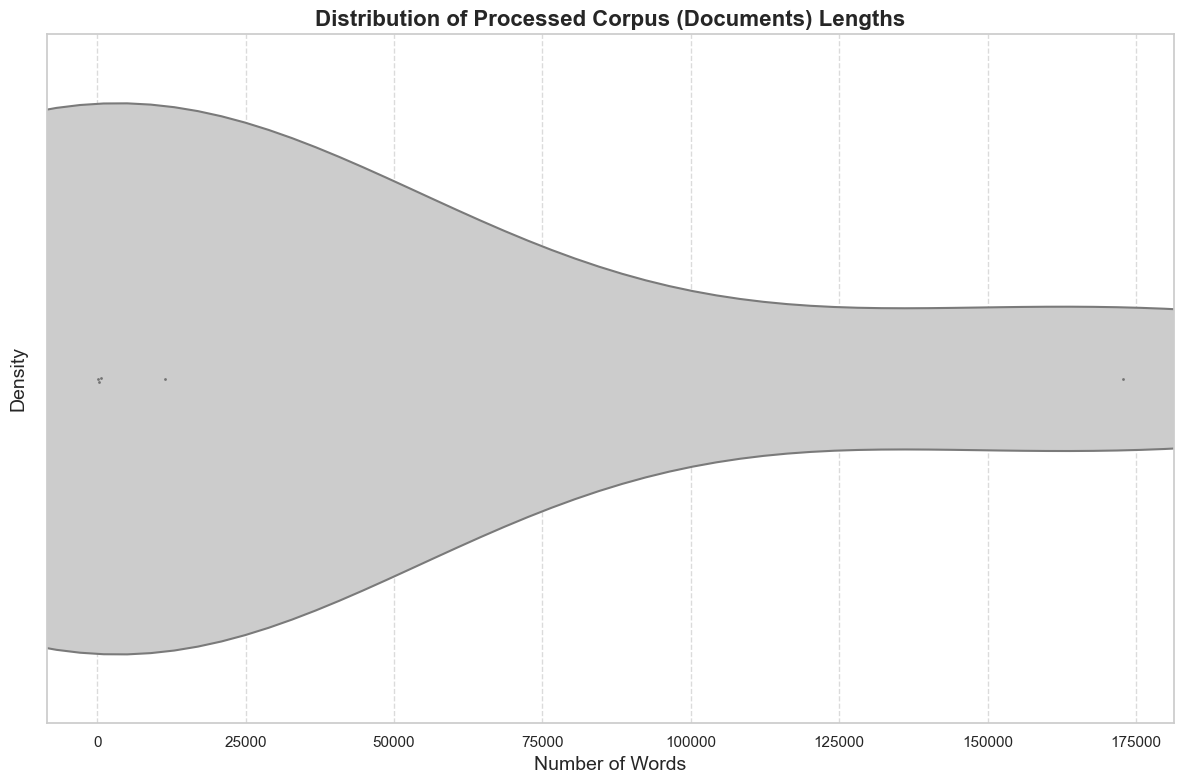

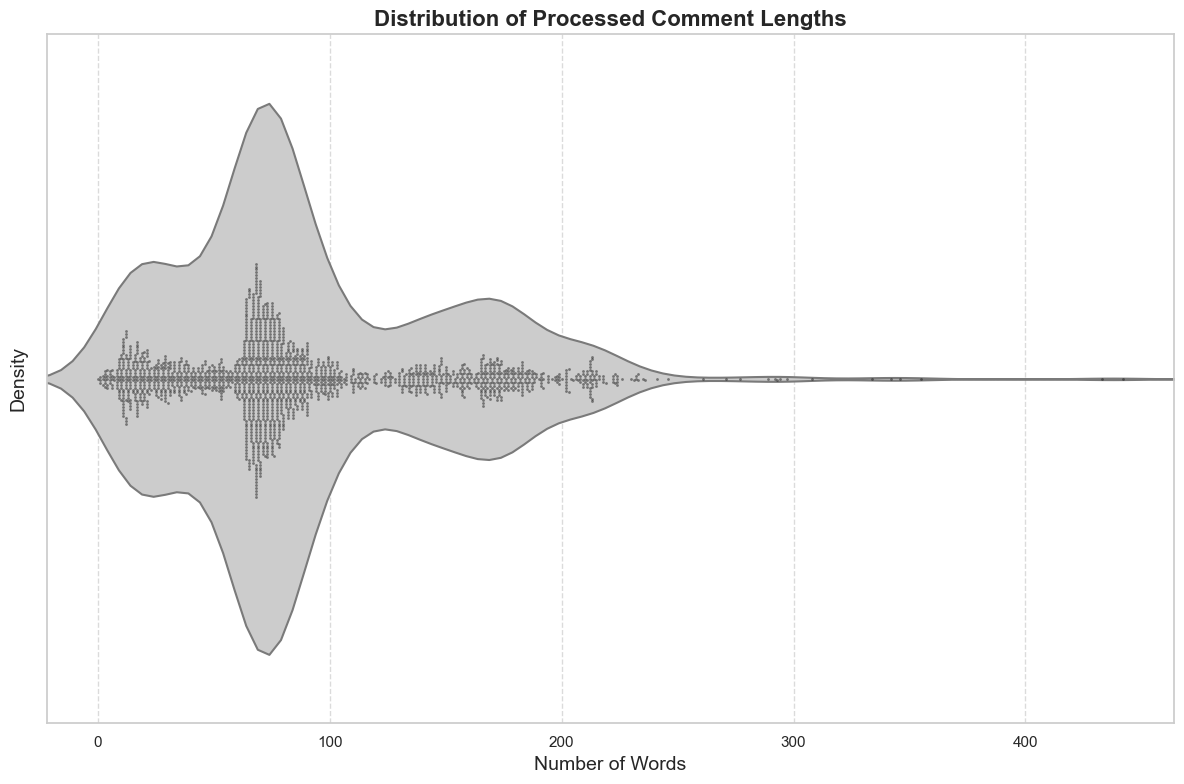

In [239]:
# Define a function to calculate lengths and plot the distribution
def plot_comment_length_distribution(df, column, title):
    """
    Function to calculate comment lengths and create a violin plot with swarm overlay.
    
    Args:
        df (DataFrame): DataFrame containing the data.
        column (str): The column containing processed text.
        title (str): Title of the plot.
    
    Returns:
        None
    """
    # Calculate the length of each comment
    df['Comment_Length'] = df[column].apply(lambda x: len(word_tokenize(str(x))))
    
    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")
    
    # Initialize the matplotlib figure
    plt.figure(figsize=(12, 8))
    
    # Create a violin plot
    sns.violinplot(x=df['Comment_Length'], inner=None, color=".8")
    
    # Overlay a swarm plot
    sns.swarmplot(x=df['Comment_Length'], size=2, color='k', alpha=0.5)
    
    # Customize the plot
    plt.title(f'Distribution of {title} Lengths', fontsize=16, fontweight='bold')
    plt.xlabel('Number of Words', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Apply the function to both DataFrames
plot_comment_length_distribution(df_docs, 'Processed_Text', "Processed Texts (Documents)")
plot_comment_length_distribution(df_comments, 'Processed_Comment', "Processed Comment")

<b>N-Grams:</b> 'workers', 'heat', and 'work' are the most common unigrams, indicating the prevalence of discussions surrounding workers conditions in the docket comments. Bi-grams show the prevalence of safety measures and policy considerations. Same with Tri-grams, showing the geographical implications regarding the docket.

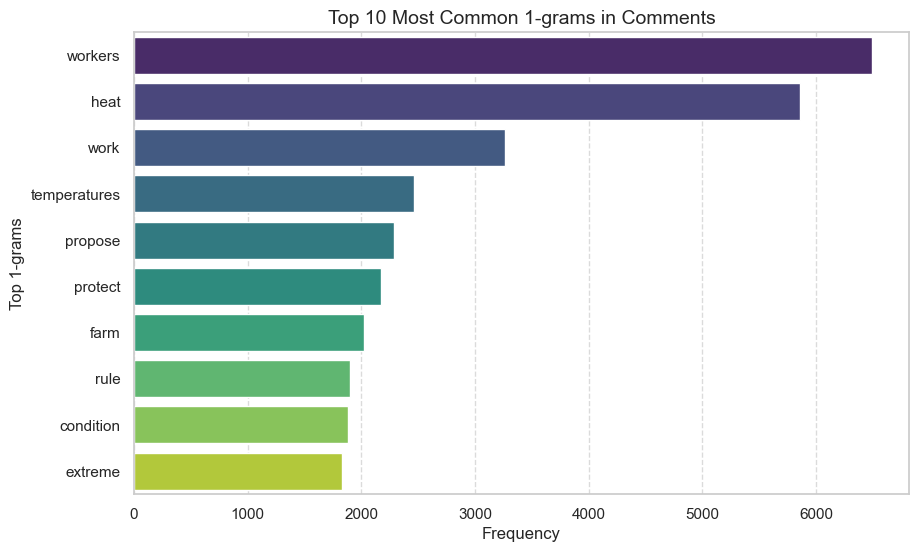

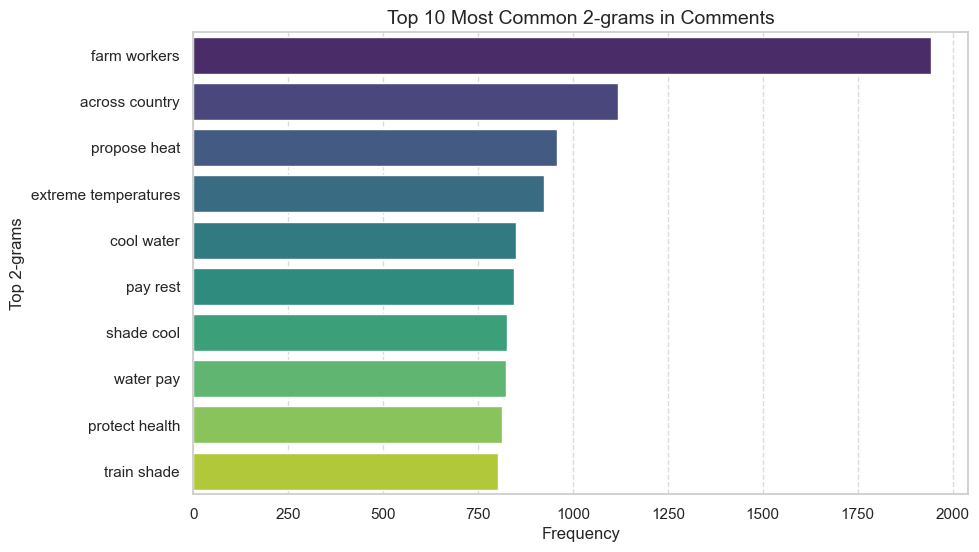

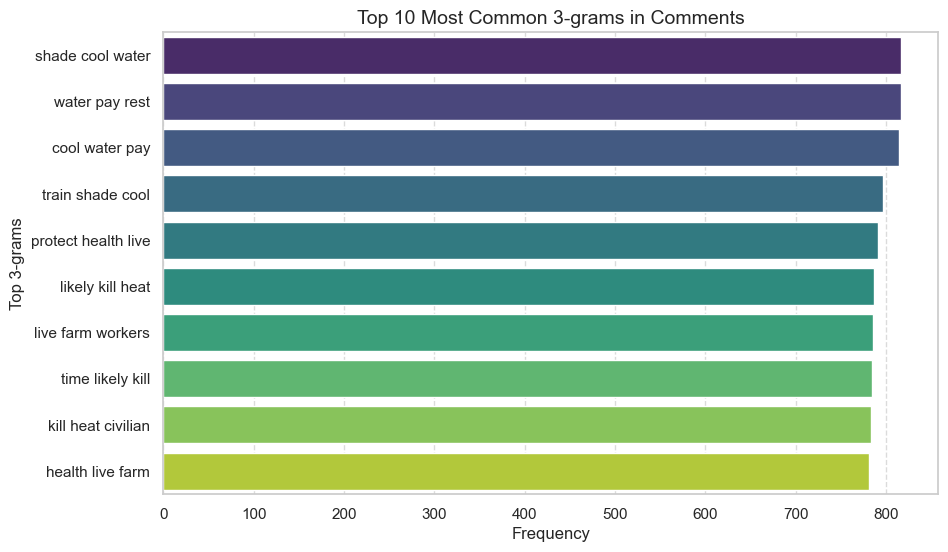

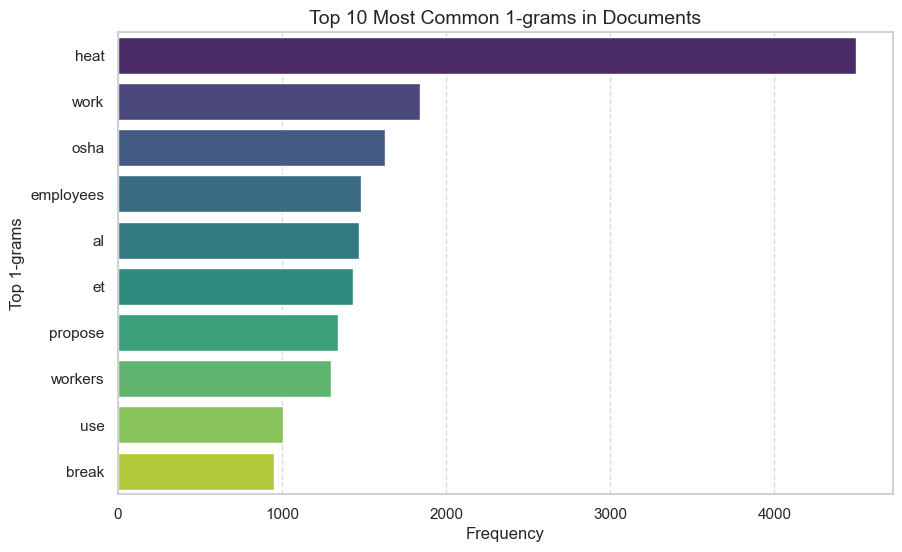

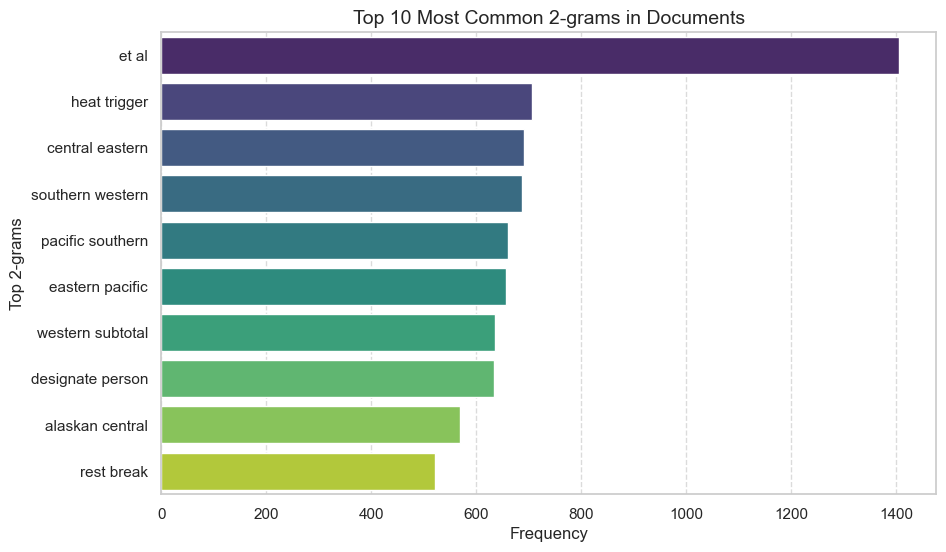

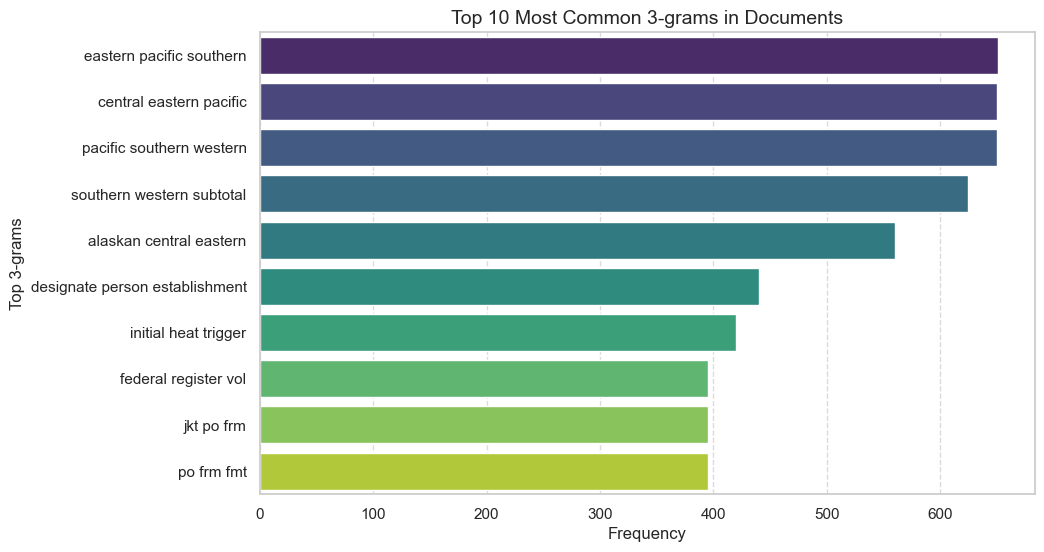

In [242]:
from nltk.util import ngrams
# Function to generate n-grams
def generate_ngrams(text, n):
    tokens = word_tokenize(text.lower())
    n_grams = ngrams(tokens, n)
    return [' '.join(grams) for grams in n_grams]

# Function to plot n-gram frequencies
def plot_ngrams(df, text_column, n, top_n=10, dataset_label=''):
    # Generate n-grams
    df[f'{n}-grams'] = df[text_column].apply(lambda x: generate_ngrams(x, n))
    
    # Flatten the list of n-grams
    all_ngrams = [ngram for sublist in df[f'{n}-grams'] for ngram in sublist]
    
    # Count the frequency of each n-gram
    ngram_freq = Counter(all_ngrams)
    
    # Get the most common n-grams
    common_ngrams = ngram_freq.most_common(top_n)
    
    # Separate the n-grams and their frequencies for plotting
    ngrams_list, frequencies = zip(*common_ngrams)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(frequencies), y=list(ngrams_list), palette='viridis')
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel(f'Top {n}-grams', fontsize=12)
    plt.title(f'Top {top_n} Most Common {n}-grams in {dataset_label}', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Plot unigrams, bigrams, and trigrams for comments
plot_ngrams(df_comments, 'Processed_Comment', 1, top_n=10, dataset_label='Comments')
plot_ngrams(df_comments, 'Processed_Comment', 2, top_n=10, dataset_label='Comments')
plot_ngrams(df_comments, 'Processed_Comment', 3, top_n=10, dataset_label='Comments')

# Plot unigrams, bigrams, and trigrams for documents
plot_ngrams(df_docs, 'Processed_Corpus', 1, top_n=10, dataset_label='Documents')
plot_ngrams(df_docs, 'Processed_Corpus', 2, top_n=10, dataset_label='Documents')
plot_ngrams(df_docs, 'Processed_Corpus', 3, top_n=10, dataset_label='Documents')

# 4. Advanced Topic Modelling for Documents

In [264]:
# Step 1: Generate tokens for the Processed_Text column and add a 'tokens' column
df_docs['Processed_Corpus_Tokens'] = df_docs['Processed_Corpus'].apply(lambda x: word_tokenize(x.lower()))
df_docs

,Document_ID,Docket_ID,Abstract,Document_Type,Title,Text,Comment_Start_Date,Comment_End_Date,Posted_Date,Corpus,Processed_Corpus,Processed_Text,tokens,Comment_Length,1-grams,2-grams,3-grams,Processed_Corpus_Tokens
0,OSHA-2021-0009-0001,OSHA-2021-0009,"Federal Register of October 27, 2021 (86 FR 59...",Proposed Rule,Heat Injury and Illness Prevention in Outdoor ...,"59309 Federal Register / Vol. 86, No. 205 / We...",2021-10-27T04:00:00Z,2022-01-27T04:59:59Z,2021-10-27T04:00:00Z,"59309 Federal Register / Vol. 86, No. 205 / We...",federal register vol wednesday october propose...,federal register vol wednesday october propose...,"[federal, register, vol, wednesday, october, p...",11413,"[federal, register, vol, wednesday, october, p...","[federal register, register vol, vol wednesday...","[federal register vol, register vol wednesday,...","[federal, register, vol, wednesday, october, p..."
1,OSHA-2021-0009-0178,OSHA-2021-0009,"Federal Register of December 3, 2021. (86 FR 6...",Proposed Rule,Heat Injury and Illness Prevention in Outdoor ...,"68594 Federal Register / Vol. 86, No. 230 / Fr...",2021-12-03T05:00:00Z,2022-01-27T04:59:59Z,2021-12-03T05:00:00Z,,,federal register vol friday december propose r...,"[federal, register, vol, friday, december, pro...",555,[],[],[],[]
2,OSHA-2021-0009-1059,OSHA-2021-0009,The purpose of this memorandum is to notify in...,Other,Memorandum Reopening the Comment Period on Hea...,"August 21, 2023 \nM\nEMORANDUM FOR: The Gene...",2023-08-22T04:00:00Z,2023-12-24T04:59:59Z,2023-08-22T04:00:00Z,,,august emorandum general public andrew levinso...,"[august, emorandum, general, public, andrew, l...",217,[],[],[],[]
3,OSHA-2021-0009-3949,OSHA-2021-0009,The purpose of this memorandum is to allow for...,Other,Memorandum Allowing OSHA’s Supporting and Rela...,Occupational Safety and Health Administration ...,2024-08-09T04:00:00Z,None,2024-08-09T04:00:00Z,,,occupational safety health administration wash...,"[occupational, safety, health, administration,...",118,[],[],[],[]
4,OSHA-2021-0009-4761,OSHA-2021-0009,"Federal Register of August 30, 20204. (89 FR 7...",Proposed Rule,Heat Injury and Illness Prevention in Outdoor ...,"70698 Federal Register / Vol. 89, No. 169 / Fr...",2024-08-30T04:00:00Z,2024-12-31T04:59:59Z,2024-08-30T04:00:00Z,,,federal register vol friday august propose rul...,"[federal, register, vol, friday, august, propo...",172773,[],[],[],[]


In [274]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
# Step 2: Use tokens from the first row
tokens = df_docs['Processed_Corpus_Tokens'].iloc[0]  # Ensure tokens are a list of Unicode tokens

# Step 3: Create a dictionary from the tokens
dictionary = Dictionary([tokens])  # Wrap tokens in a list because Dictionary expects a list of lists



# Step 3: Create the corpus (Bag of Words format)
corpus = [dictionary.doc2bow(tokens) for tokens in df_docs['Processed_Corpus_Tokens']]

# Step 4: Set parameters for LDA
num_topics = 5  # Adjust as needed
passes = 10
iterations = 100

# Step 5: Build the LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=passes,
    iterations=iterations,
    alpha='auto',
    per_word_topics=True
)

# Step 6: Print the topics discovered
topics = lda_model.print_topics(num_topics=num_topics, num_words=5)
for idx, topic in topics:
    print(f"Topic {idx + 1}: {topic}")

Topic 1: 0.024*"heat" + 0.010*"work" + 0.009*"osha" + 0.008*"employees" + 0.008*"al"
Topic 2: 0.003*"heat" + 0.001*"osha" + 0.001*"work" + 0.001*"employees" + 0.001*"al"
Topic 3: 0.003*"heat" + 0.001*"et" + 0.001*"work" + 0.001*"employees" + 0.001*"use"
Topic 4: 0.009*"heat" + 0.005*"work" + 0.004*"al" + 0.004*"propose" + 0.004*"osha"
Topic 5: 0.002*"heat" + 0.001*"osha" + 0.001*"work" + 0.001*"propose" + 0.001*"employees"


In [272]:
from gensim.models import LdaModel

# Set parameters
num_topics = 10  # Adjust as needed
passes = 10
iterations = 100

# Build LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=100, passes=passes, iterations=iterations, alpha='auto', per_word_topics=True)

In [275]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Prepare the visualization
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(vis_data)

# Geographical Analysis

<b>Geocoding:</b> Finding Coordinates by City

In [280]:
city_coords = pd.read_csv(r'c:\Users\U355394\Desktop\worldcities.csv')  # Adjust the filename as needed
# Rename the column to 'City'
city_coords.rename(columns={'city': 'City'}, inplace=True)
# Merge on 'City' column
df_merged = pd.merge(df_comments, city_coords, on='City', how='left')
# Remove rows with missing coordinates
df_merged = df_merged.dropna(subset=['lat', 'lng'])

We find 1,219 cities with coordinates

In [ ]:
df_merged.drop_duplicates(subset=['Comment_ID']).reset_index(drop=True)

,Comment_ID,Document_ID,AgencyID,City,Comment,Docket_ID,DocumentType,Time of Comment,Unnamed: 8,Processed_Comments,...,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,OSHA-2021-0009-5793,OSHA-2021-0009-4761,OSHA,Montague,On two days this summer the temperature reache...,OSHA-2021-0009,Public Submission,2024-09-12 16:57:40,NaN,two days summer temperature reach everyday wee...,...,Montague,42.5549,-72.5177,United States,US,USA,Massachusetts,NaN,8527.0,1.840053e+09
1,OSHA-2021-0009-7601,OSHA-2021-0009-4761,OSHA,Chicago,We urge you to implement the proposed heat reg...,OSHA-2021-0009,Public Submission,2024-09-18 18:45:56,NaN,urge implement propose heat regulations standa...,...,Chicago,41.8375,-87.6866,United States,US,USA,Illinois,NaN,8497759.0,1.840000e+09
2,OSHA-2021-0009-7700,OSHA-2021-0009-4761,OSHA,San Francisco,Please implement the proposed heat regulations...,OSHA-2021-0009,Public Submission,2024-09-19 12:59:15,NaN,please implement propose heat regulations abso...,...,San Francisco,37.7558,-122.4449,United States,US,USA,California,NaN,3364979.0,1.840022e+09
3,OSHA-2021-0009-15101,OSHA-2021-0009-4761,OSHA,Watsonville,"As a former worker on a school campus, I fully...",OSHA-2021-0009,Public Submission,2024-10-09 20:29:47,NaN,former worker school campus fully support occu...,...,Watsonville,36.9206,-121.7708,United States,US,USA,California,NaN,68020.0,1.840022e+09
4,OSHA-2021-0009-9226,OSHA-2021-0009-4761,OSHA,Vancouver,Please implement the proposed heat regulations...,OSHA-2021-0009,Public Submission,2024-09-24 14:05:33,NaN,please implement propose heat regulationsthese...,...,Vancouver,49.2500,-123.1000,Canada,CA,CAN,British Columbia,NaN,2426160.0,1.124825e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,OSHA-2021-0009-5021,OSHA-2021-0009-4761,OSHA,San Diego,"Hello,<br/><br/>I am writing to urge you to im...",OSHA-2021-0009,Public Submission,2024-09-09 20:05:37,NaN,helloi write urge implement propose heat regul...,...,San Diego,32.8313,-117.1222,United States,US,USA,California,NaN,3046560.0,1.840022e+09
1217,OSHA-2021-0009-4931,OSHA-2021-0009-4761,OSHA,Berkeley,Farmer workers are life givers - they literall...,OSHA-2021-0009,Public Submission,2024-09-09 18:29:44,NaN,farmer workers life givers literally fee entir...,...,Berkeley,37.8722,-122.2760,United States,US,USA,California,NaN,121385.0,1.840019e+09
1218,OSHA-2021-0009-6749,OSHA-2021-0009-4761,OSHA,Fort Irwin,Please implement the proposed heat regulations...,OSHA-2021-0009,Public Submission,2024-09-17 13:49:37,NaN,please implement propose heat regulationsthese...,...,Fort Irwin,35.2477,-116.6834,United States,US,USA,California,NaN,8967.0,1.840026e+09
1219,OSHA-2021-0009-16750,OSHA-2021-0009-4761,OSHA,Westmont,For the first 5 years of my career in public e...,OSHA-2021-0009,Public Submission,2024-10-10 12:05:13,NaN,first years career public education work schoo...,...,Westmont,33.9417,-118.3018,United States,US,USA,California,NaN,35345.0,1.840028e+09


Let's create the map

In [ ]:
df_merged.columns

Index(['Comment_ID', 'Document_ID', 'AgencyID', 'City', 'Comment', 'Docket_ID',
       'DocumentType', 'Time of Comment', 'Unnamed: 8', 'Processed_Comments',
       'Is_Duplicate', 'tokens', 'Comment_Length', '1-grams', '2-grams',
       '3-grams', 'compound', 'city_ascii', 'lat', 'lng', 'country', 'iso2',
       'iso3', 'admin_name', 'capital', 'population', 'id'],
      dtype='object')

In [ ]:
import folium
from folium.plugins import HeatMap

# Initialize the map centered around the mean coordinates
m = folium.Map(location=[df_merged['lat'].mean(), df_merged['lng'].mean()], zoom_start=5)

# Prepare heatmap data
heat_data = [
    [row['lat'], row['lng'], row['compound']]
    for index, row in df_merged.iterrows()
    if not pd.isnull(row['lat']) and not pd.isnull(row['lng'])
]


# Create the map
m = folium.Map(location=[df_merged['lat'].mean(), df_merged['lng'].mean()], zoom_start=5)

# Add HeatMap
HeatMap(heat_data, radius=15, blur=10, max_zoom=1).add_to(m)

m

[[42.5549, -72.5177, -0.9571], [41.8375, -87.6866, -0.9413], [37.7558, -122.4449, 0.6124], [30.7841, -112.518, 0.6124], [8.51, 125.98, 0.6124], [-31.4356, -62.0714, 0.6124], [10.65, 124.35, 0.6124], [13.7, -88.1, 0.6124], [9.9083, -84.0582, 0.6124], [16.7833, -89.9361, 0.6124]]


# Sentiment Analysis

<b>Polarity Analysis:</b> Comments tend to express either very positive or very negative sentiments. Moderate Sentiments are underrepresented.

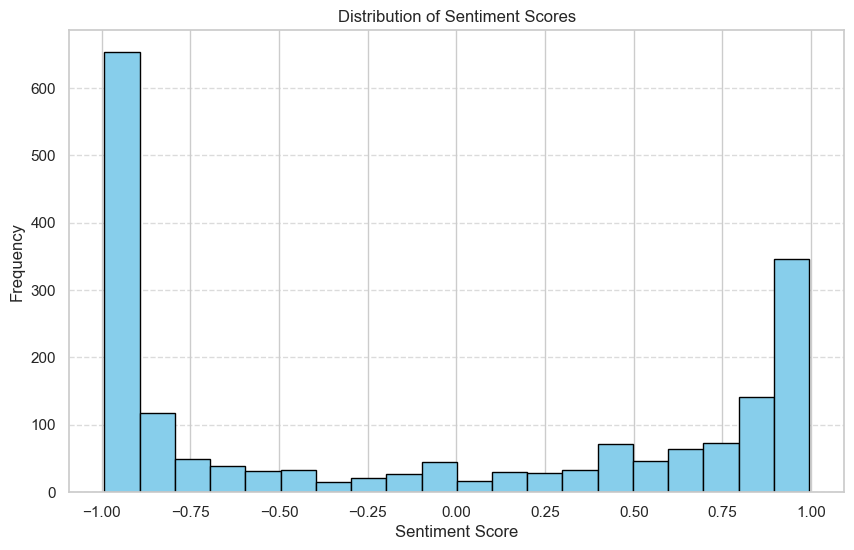

In [ ]:
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Compute sentiment scores
df_comments['compound'] = df_comments['Processed_Comment'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(df_comments['compound'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


<b>Creation of a sentiment analyzer</b>

In [281]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

# create get_sentiment function
analyzer = SentimentIntensityAnalyzer()
def get_sentiment(text):

    scores = analyzer.polarity_scores(text)

    sentiment = 1 if scores['pos'] > 0 else 0

    return sentiment


# apply get_sentiment function

df_comments['sentiment'] = df_comments['Processed_Comment'].apply(get_sentiment)

df_comments.head()

,index,Comment_ID,Document_ID,AgencyID,City,Comment,Docket_ID,DocumentType,Time of Comment,Processed_Comment,...,Is_Duplicate,Time_Difference,Duplicate_Classification,tokens,Comment_Length,1-grams,2-grams,3-grams,compound,sentiment
0,0,OSHA-2021-0009-4889,OSHA-2021-0009-4761,OSHA,Oceanside,I sincerely ask our people to consider impleme...,OSHA-2021-0009,Public Submission,2024-09-09 17:30:11,,...,True,NaT,First Occurrence,[],0,[],[],[],0.0000,0
1,146,OSHA-2021-0009-5224,OSHA-2021-0009-4761,OSHA,Cockeysville,"As ab ex restaurant worker, I urge the Occupat...",OSHA-2021-0009,Public Submission,2024-09-10 17:06:57,ab ex restaurant worker urge occupational safe...,...,False,NaT,Unique,"[ab, ex, restaurant, worker, urge, occupationa...",45,"[ab, ex, restaurant, worker, urge, occupationa...","[ab ex, ex restaurant, restaurant worker, work...","[ab ex restaurant, ex restaurant worker, resta...",0.2023,1
2,147,OSHA-2021-0009-13753,OSHA-2021-0009-4761,OSHA,Buffalo,It is absolutely necessary to implement the pr...,OSHA-2021-0009,Public Submission,2024-10-09 20:14:14,absolutely necessary implement propose heat re...,...,False,NaT,Unique,"[absolutely, necessary, implement, propose, he...",68,"[absolutely, necessary, implement, propose, he...","[absolutely necessary, necessary implement, im...","[absolutely necessary implement, necessary imp...",-0.9538,1
3,148,OSHA-2021-0009-4852,OSHA-2021-0009-4761,OSHA,NaN,This is absolutely necessary and I am PM for a...,OSHA-2021-0009,Public Submission,2024-09-09 16:33:17,absolutely necessary pm general contractor bel...,...,False,NaT,Unique,"[absolutely, necessary, pm, general, contracto...",9,"[absolutely, necessary, pm, general, contracto...","[absolutely necessary, necessary pm, pm genera...","[absolutely necessary pm, necessary pm general...",0.0772,1
4,149,OSHA-2021-0009-18678,OSHA-2021-0009-4761,OSHA,NaN,We absolutely need heat protections for the wo...,OSHA-2021-0009,Public Submission,2024-11-13 15:56:26,absolutely need heat protections workplace wor...,...,False,NaT,Unique,"[absolutely, need, heat, protections, workplac...",99,"[absolutely, need, heat, protections, workplac...","[absolutely need, need heat, heat protections,...","[absolutely need heat, need heat protections, ...",-0.7096,1


<b>Time trend analysis</b> Very inconsistent sentiment trend over time

<b>Subjectivity and Polarity</b>

In [285]:
from textblob import TextBlob
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# get polarity:

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

df_comments['Subjectivity'] = df_comments['Processed_Comment'].apply(get_subjectivity)

df_comments['Polarity'] = df_comments['Processed_Comment'].apply(get_polarity)

df_comments['Polarity']

0       0.000000
1      -0.047917
2      -0.085331
3       0.025000
4      -0.081429
          ...   
1876    0.000000
1877    0.098333
1878   -0.138333
1879    0.148750
1880    0.284091
Name: Polarity, Length: 1881, dtype: float64

<b>Proportion of neutral, positive, negative sentiments using SentimentIntensityAnalyzer</b>

In [286]:
def getSIA(text):
    sia = SentimentIntensityAnalyzer()
    sentiment= sia.polarity_scores(text)
    return sentiment

# get Sentiment score for each day:
compound=[]
neg=[]
pos=[]
neu=[]
SIA=0

for i in range (0, len(df_comments['Processed_Comment'])):
    SIA= getSIA(df_comments['Processed_Comment'][i])
    neg.append(SIA['neg'])
    pos.append(SIA['pos'])
    neu.append(SIA['neu'])

In [288]:
df_comments['neg']= neg
df_comments['pos']=pos
df_comments['neu']=neu

<b>Work Cloud Sentiment Analysis</b>

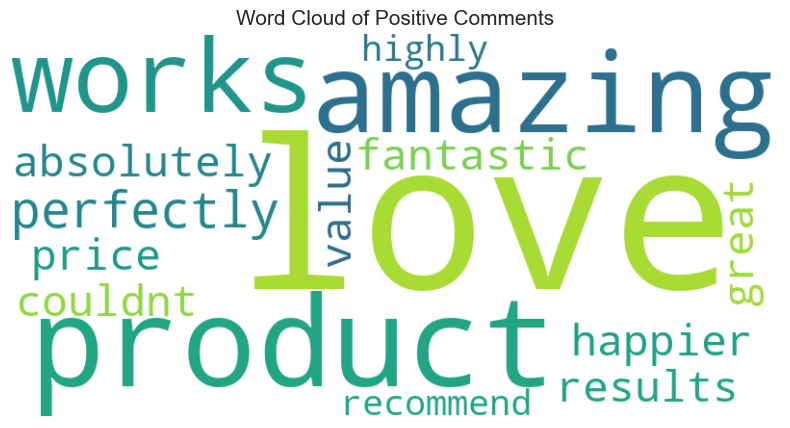

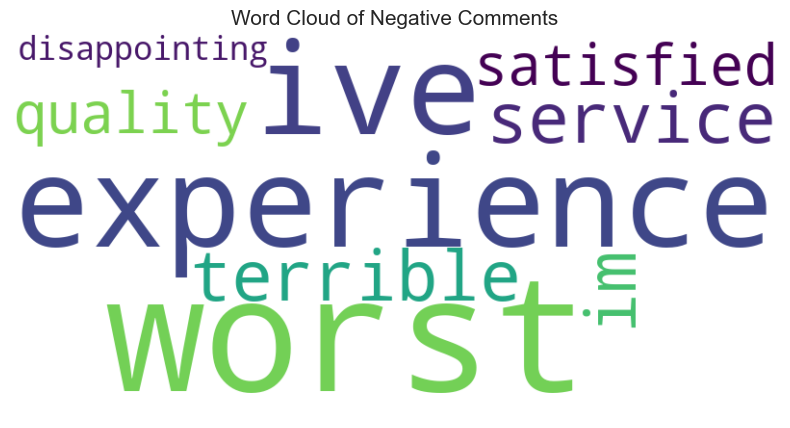

In [290]:
import string

# Sample DataFrame (replace with your actual DataFrame)
data = {'Processed_Comment': [
 "I love this product! It's amazing and works perfectly.",
 "This is the worst experience I've ever had. Terrible service.",
 "Absolutely fantastic! Couldn't be happier with the results.",
 "I'm not satisfied with the quality. Very disappointing.",
 "Great value for the price. Highly recommend it."
]}
df_comments = pd.DataFrame(data)

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores
df_comments['Sentiment'] = df_comments['Processed_Comment'].apply(lambda x: sia.polarity_scores(x))
df_comments['Compound'] = df_comments['Sentiment'].apply(lambda x: x['compound'])

# Define positive and negative comments
positive_comments = df_comments[df_comments['Compound'] > 0]['Processed_Comment']
negative_comments = df_comments[df_comments['Compound'] < 0]['Processed_Comment']

# Function to preprocess text
def preprocess_text(text):
 # Convert to lowercase
 text = text.lower()
 # Remove punctuation
 text = text.translate(str.maketrans('', '', string.punctuation))
 # Remove stopwords
 stop_words = set(stopwords.words('english'))
 text = ' '.join(word for word in text.split() if word not in stop_words)
 return text

# Generate word cloud
def generate_wordcloud(text, title):
 wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
 plt.figure(figsize=(10, 5))
 plt.imshow(wordcloud, interpolation='bilinear')
 plt.title(title, fontsize=15)
 plt.axis('off')
 plt.show()

# Preprocess and combine positive comments
positive_text = ' '.join(positive_comments.apply(preprocess_text))
generate_wordcloud(positive_text, 'Word Cloud of Positive Comments')

# Preprocess and combine negative comments
negative_text = ' '.join(negative_comments.apply(preprocess_text))
generate_wordcloud(negative_text, 'Word Cloud of Negative Comments')

In [292]:
df_comments

,Processed_Comment,Sentiment,Compound
0,I love this product! It's amazing and works pe...,"{'neg': 0.0, 'neu': 0.324, 'pos': 0.676, 'comp...",0.9259
1,This is the worst experience I've ever had. Te...,"{'neg': 0.474, 'neu': 0.526, 'pos': 0.0, 'comp...",-0.8020
2,Absolutely fantastic! Couldn't be happier with...,"{'neg': 0.214, 'neu': 0.463, 'pos': 0.323, 'co...",0.3419
3,I'm not satisfied with the quality. Very disap...,"{'neg': 0.493, 'neu': 0.507, 'pos': 0.0, 'comp...",-0.7027
4,Great value for the price. Highly recommend it.,"{'neg': 0.0, 'neu': 0.35, 'pos': 0.65, 'compou...",0.8516


In [291]:
# Aggregate sentiment scores by date
sentiment_daily = df_comments.groupby('Date').mean()[['Neg', 'Neu', 'Pos']]

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(sentiment_daily.T, annot=True, cmap='coolwarm', cbar_kws={'label': 'Average Sentiment Score'})
plt.title('Sentiment Heatmap Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.show()

KeyError: 'Date'

# Geographic Analysis